In [1]:
import rdflib
import time
import json
import re
import csv

# from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt

def format_result(res):
    """
    permet de formater les stats avant de les sauvegarder/afficher
    :param res: resultat d'un get_stats()
    :return: res formaté
    """

    def check_len_str(stat):
        """
        Si la longeure de la chaine de caractère est trop importante, on la coupe après 100 caractères
        :param stat: chaine de caractère
        :return: chaine de caractère tronquée
        """
        if isinstance(stat, str):
            if len(stat) > 100:
                return stat[:100] + "..."
            else:
                return stat
        else:
            return stat

    cleaned_res = {}
    for key, stat in res.items():
        cleaned_res[key] = {}
        if isinstance(stat, dict):
            # on selectionne uniquement les 10 plus fréquents items si il y en a plus de 10,
            # et on tronque leurs longueures
            nested = False
            for value in list(stat.values()):
                if isinstance(value, dict):
                    nested = True
            if not nested:
                if len(list(stat.items())) > 10:
                    cleaned_res[check_len_str(key)] = dict([(check_len_str(k), v) for k, v in sorted(stat.items(), key=lambda item: item[1], reverse=True)][:10])
                else:
                    cleaned_res[check_len_str(key)] = stat
            else:
                # si il y a une couche de plus, on selectionne les 10 premiers elements et on tronque leurs longueure
                for key_stat, stat_value in stat.items():
                    if isinstance(stat_value, dict):
                        if len(list(stat_value.items())) > 10:
                            cleaned_res[check_len_str(key)][check_len_str(key_stat)] = dict([(check_len_str(k), v) for k, v in sorted(stat_value.items(), key=lambda item: item[1], reverse=True)][:10])
                        else:
                            cleaned_res[check_len_str(key)][check_len_str(key_stat)] = stat_value
                    else:
                        cleaned_res[check_len_str(key)][check_len_str(key_stat)] = stat_value
        # si c'est un entier, on tronque juste la taille de la clef
        elif isinstance(stat, int):
            cleaned_res[check_len_str(key)] = stat

    # on affiche le resultat avant la sauvegarde
    json_print = json.dumps(cleaned_res, indent=2, ensure_ascii=False)
    print(json_print)
    return cleaned_res

def text_between_parentheses(text):
    n = 1  # run at least once
    parenthese = []
    while n:
        if re.search(r'\([^()]*\)', text):
            parenthese.append(re.search(r'\([^()]*\)', text).group(0))
        text, n = re.subn(r'\([^()]*\)', '', text)  # remove non-nested/flat balanced parts
    return parenthese

# Rapport sur les données complêtes

## Par base de donnée:
### ADP

#### Global

In [15]:
start_loading_data_time = time.time()
# Loading des données sauvegardées dans la mémoire ram
g_book_ADP = rdflib.Graph()
g_author_ADP = rdflib.Graph()
ADP_book_graph = g_book_ADP.parse("../Graphes/grapheADPLivres.rdf")
ADP_author_graph = g_author_ADP.parse("../Graphes/grapheADPAuteurs.rdf")

ADP_books = {}
# Analyse des données ADP à partir des graphs
# parcour des triplets du graph
for subj, pred in g_book_ADP.subject_predicates(rdflib.URIRef("http://www.sogides.com/classe/Livre")):
    book_ADP = g_book_ADP.predicate_objects(subj)

    for info in book_ADP:
        if info[0].split("/")[-1] not in ADP_books:
            ADP_books[info[0].split("/")[-1]] = 0
            ADP_books[info[0].split("/")[-1] + "_by_value"] = {"None":0}
        if info[1]:
            ADP_books[info[0].split("/")[-1]] += 1
            if info[1] not in ADP_books[info[0].split("/")[-1] + "_by_value"]:
                ADP_books[info[0].split("/")[-1] + "_by_value"][info[1]] = 0
            ADP_books[info[0].split("/")[-1] + "_by_value"][info[1]] += 1
        else:
            ADP_books[info[0].split("/")[-1] + "_by_value"]["None"] += 1
        

ADP_loading_time = time.time()
print("ADP_loading_time: ", ADP_loading_time - start_loading_data_time)
res = format_result(ADP_books)


ADP_loading_time:  13.60962986946106
{
  "publisher": 15469,
  "publisher_by_value": {
    "http://www.sogides.com/editeur/18": 2282,
    "http://www.sogides.com/editeur/20": 1211,
    "http://www.sogides.com/editeur/29": 979,
    "http://www.sogides.com/editeur/34": 978,
    "http://www.sogides.com/editeur/36": 833,
    "http://www.sogides.com/editeur/3": 782,
    "http://www.sogides.com/editeur/24": 779,
    "http://www.sogides.com/editeur/33": 759,
    "http://www.sogides.com/editeur/16": 752,
    "http://www.sogides.com/editeur/11": 734
  },
  "22-rdf-syntax-ns#type": 15469,
  "22-rdf-syntax-ns#type_by_value": {
    "None": 0,
    "http://www.sogides.com/classe/Livre": 15469
  },
  "author": 17266,
  "author_by_value": {
    "http://www.sogides.com/auteur/473": 676,
    "http://www.sogides.com/auteur/494": 215,
    "http://www.sogides.com/auteur/479": 196,
    "http://www.sogides.com/auteur/495": 192,
    "http://www.sogides.com/auteur/132": 173,
    "http://www.sogides.com/auteur/


#### Commentaires:
On a 15469 livres référencés.
- On a un isbn unique par livre: ADP fait la différence entre les éditions
- On a un isbn pour chaque livre, pas d'isbn non indiqué
- sujet théma présent pour 59% des livres
- sujet théma principale présent pour 52% des livres
- description présente pour 45% des livres
- description promotionnelle présent pour 10% des livres
- editeur présent pour tout les livres
- titre présent pour tout les livres
- 75 commentaire en tout

### ILE

#### Global

In [33]:
start_loading_data_time = time.time()
g_item_ILE = rdflib.Graph()
item_graph_ILE = g_item_ILE.parse("../Graphes/grapheILE.rdf")
ILE_books = {"author": 0, "author_by_value": {"None": 0}}
editor_finding = {}
for subj, pred in g_item_ILE.subject_predicates(rdflib.URIRef("http://recif.litterature.org/ontologie/classe/oeuvre")):
    ILE_book = g_item_ILE.predicate_objects(subj)

    # pour chaque coupe prédictat-objet
    for info in ILE_book:
        
        if info[0] == rdflib.URIRef("https://schema.org/author"):
            author_ILE = g_item_ILE.predicate_objects(info[1])
            for author_info in author_ILE:
                if author_info[0] == rdflib.URIRef("https://schema.org/name"):
                    
                    if author_info[1] not in ILE_books["author_by_value"]:
                        ILE_books["author_by_value"][author_info[1]] = 0
                    ILE_books["author_by_value"][author_info[1]] += 1
                    if author_info[1]:
                        ILE_books["author"] += 1
                    else:
                        ILE_books["author_by_value"]["None"] += 1
        else:            
            if info[0].split("/")[-1] not in ILE_books:
                ILE_books[info[0].split("/")[-1]] = 0
                ILE_books[info[0].split("/")[-1] + "_by_value"] = {"None":0}
            if info[1]:
                ILE_books[info[0].split("/")[-1]] += 1
                if info[1] not in ILE_books[info[0].split("/")[-1] + "_by_value"]:
                    ILE_books[info[0].split("/")[-1] + "_by_value"][info[1]] = 0
                ILE_books[info[0].split("/")[-1] + "_by_value"][info[1]] += 1
            else:
                ILE_books[info[0].split("/")[-1] + "_by_value"]["None"] += 1
            
        if info[0].split("/")[-1] == "bookEdition" or info[0].split("/")[-1] == "isbn":
            if subj not in editor_finding:
                editor_finding[subj] = {}
            if info[0].split("/")[-1] == "bookEdition":
                if info[1]:
                    editor_finding[subj]["editor"] = info[1]
            if info[0].split("/")[-1] == "isbn":
                if info[1] and "(" in info[1]:
                    txt_parentheses = text_between_parentheses(info[1])
                    if txt_parentheses:
                        editor_finding[subj]["isbn"] = txt_parentheses[0]
                    
ILE_loading_time = time.time()
print("ILE_loading time: ", ILE_loading_time - start_loading_data_time)
res = format_result(ILE_books)


ILE_loading time:  27.75906229019165
{
  "author": 27109,
  "author_by_value": {
    "Groulx, Lionel": 208,
    "Thériault, Yves": 203,
    "Tremblay, Michel": 202,
    "Tibo, Gilles": 197,
    "Bergeron, Alain M.": 178,
    "Major, Henriette": 151,
    "Blais, Marie-Claire": 149,
    "Gagnon, Cécile": 148,
    "Paradis, Raymond": 142,
    "Beaulieu, Victor-Lévy": 141
  },
  "22-rdf-syntax-ns#type": 27109,
  "22-rdf-syntax-ns#type_by_value": {
    "None": 0,
    "http://recif.litterature.org/ontologie/classe/oeuvre": 27109
  },
  "datePublished": 27008,
  "datePublished_by_value": {
    "2009": 857,
    "2006": 781,
    "2007": 762,
    "2008": 749,
    "2000": 709,
    "2005": 701,
    "2010": 698,
    "1997": 697,
    "1999": 697,
    "2001": 691
  },
  "lieuPublication": 26615,
  "lieuPublication_by_value": {
    "Montréal": 11618,
    "[Montréal]": 1676,
    "Québec": 1310,
    "Saint-Lambert": 1102,
    "Paris": 845,
    "Saint-Laurent": 615,
    "Trois-Rivières": 533,
    "Toront

#### Commentaires

27109 livres au total
- 5931 isbn vide : soit 21%
- 405 isbn sont composé de seulement de texte entre parenthèse
exemple d'isbn

In [34]:
exemple = {}
compte = {}
compte_minus = {"sans":0, "avec":0}

for isbn_ls in ILE_books["isbn_by_value"]:
    isbn_ls = re.split("[|;,]", isbn_ls)
    if len(isbn_ls) not in compte:
        compte[len(isbn_ls)] = 0
    compte[len(isbn_ls)] += 1
    for isbn in isbn_ls:
        if isbn:
            if "-" in isbn:
                compte_minus["avec"] += 1
            else:
                compte_minus["sans"] += 1
            if "(" in isbn:
                txt_parentheses = text_between_parentheses(isbn)
                for ex in txt_parentheses:
                    if ex not in exemple:
                        exemple[ex] = 0
                    exemple[ex] += 1
exemple = [(k, v) for k, v in sorted(exemple.items(), key=lambda item: item[1], reverse=True)]
compte = [(k, v) for k, v in sorted(compte.items(), key=lambda item: item[0], reverse=False)]
for ex, nb in exemple[:30]:
    print("exemple de texte entre parenthèses dans les isbns: ", ex, ": ", nb)

print("\n Nombre d'isbn par livre")
for cpt, nb in compte:
    print(nb, " livres ont ", nb, " isbns")
print("\n Nombre d'isbn avec séparation par block (ex: '2-7644-0049-7'): ", compte_minus["avec"], ' et sans: ', compte_minus["sans"])

print("test de récupération des editeurs a partir des isbns et inversement")
isbn_editor_count = {"editor and isbn": 0, "isbn": 0, "editor": 0, "None": 0}
isbn_editor_by_value = {"editor and isbn": {}, "isbn": {}, "editor": {}}
for subj, book in editor_finding.items():
    if "editor" in book and "isbn" in book:
        isbn_editor_count["editor and isbn"] += 1
        if book["editor"] + " " + book["isbn"] not in isbn_editor_by_value["editor and isbn"]:
            isbn_editor_by_value["editor and isbn"][book["editor"] + " " + book["isbn"]] = 0
        isbn_editor_by_value["editor and isbn"][book["editor"] + " " + book["isbn"]] += 1
    elif "isbn" in book:
        if book["isbn"] not in isbn_editor_by_value["isbn"]:
            isbn_editor_by_value["isbn"][book["isbn"]] = 0
        isbn_editor_by_value["isbn"][book["isbn"]] += 1
        isbn_editor_count["isbn"] += 1
    else:
        isbn_editor_count["None"] += 1
_ = format_result(isbn_editor_by_value)
        


exemple de texte entre parenthèses dans les isbns:  (br.) :  8892
exemple de texte entre parenthèses dans les isbns:  (rel.) :  648
exemple de texte entre parenthèses dans les isbns:  (vol. 1) :  147
exemple de texte entre parenthèses dans les isbns:  (vol. 2) :  121
exemple de texte entre parenthèses dans les isbns:  (t. 1) :  88
exemple de texte entre parenthèses dans les isbns:  (rel. à spirale) :  72
exemple de texte entre parenthèses dans les isbns:  (vol. 3) :  58
exemple de texte entre parenthèses dans les isbns:  (Écrits des Forges) :  57
exemple de texte entre parenthèses dans les isbns:  (Leméac) :  56
exemple de texte entre parenthèses dans les isbns:  (Actes sud) :  55
exemple de texte entre parenthèses dans les isbns:  (br) :  53
exemple de texte entre parenthèses dans les isbns:  (t. 2) :  52
exemple de texte entre parenthèses dans les isbns:  (t. 3) :  31
exemple de texte entre parenthèses dans les isbns:  (cart.) :  25
exemple de texte entre parenthèses dans les isbns: 

{'editor and isbn': {rdflib.term.Literal('Dominique et compagnie, À pas de loup. Niveau 3 (br.)'): 17,
  rdflib.term.Literal('Héritage (br.)'): 14,
  rdflib.term.Literal('Actes sud ; [Montréal] (Leméac)'): 13,
  rdflib.term.Literal('Leméac ; [Arles France] (Leméac)'): 12,
  rdflib.term.Literal('Lidec, Célébrités (br.)'): 11,
  rdflib.term.Literal('Dominique et compagnie, À pas de loup. Niveau 2 (br.)'): 11,
  rdflib.term.Literal('Éducation Québec ; [Montréal] (rel.)'): 10,
  rdflib.term.Literal('Dominique & Friends, 1999, [32] p. (br.)'): 9,
  rdflib.term.Literal('Le Sablier inc., Collection Tic tac toc. Série Tic, 1978, 15 p. (br.)'): 9,
  rdflib.term.Literal('Publications Graficor, Collection Tic tac toc. Série Tic, 1983, 15 p. (br.)'): 9},
 'isbn': {'(rel.)': 2},
 'editor': {rdflib.term.Literal('Fides, Collection du nénuphar'): 59,
  rdflib.term.Literal('Dominique et compagnie, 2009'): 38,
  rdflib.term.Literal('La Courte échelle, 2001'): 36,
  rdflib.term.Literal('Québec Amérique, 

- On peut voir que l'on peut pas récupérerl'information de l'éditeur à partir des parenthèses des isbns, car si l'editeur est entre parenthèse, le champs "éditeur" n'est pas vide
- certain livres ont plusieur isbn: 793 livres ont 2 isbn, 87 en ont 3, etc....
- les informations entre parenthèses sont multiples: 
    - "br." (8892)
    - "rel." (648)
    - "vol." 
    - "t."
    - editeurs
- les autres informations sont prinicpalements complêtes, pas de problème majeur.

### Dépot-légal

#### Global


In [5]:
start_loading_data_time = time.time()
g_book_DL = rdflib.Graph()
g_book_DL.parse("../Graphes/grapheDepotLegal.rdf")

DL_books = {
    "author": 0,
    "author_by_value": {"None": 0},
    "editor": 0,
    "editor_by_value": {"None": 0},
}
compte_isbn = {}
compte_author = {}
name_dict = {}
isbn_dict = {}
author_dict = {}

for subj, pred in g_book_DL.subject_predicates(rdflib.URIRef("http://dbpedia.org/ontology/Book")):
    author_dict[subj] = None
    DL_book = g_book_DL.predicate_objects(subj)
    # pour chaque coupe prédictat-objet
    for info in DL_book:
        
        if info[0] == rdflib.URIRef("https://schema.org/author"):
            author_DL = g_book_DL.predicate_objects(info[1])
            familyName = ""
            givenName = ""
            for author_info in author_DL:
                if author_info[0] == rdflib.URIRef("https://schema.org/givenName"):
                    givenName = author_info[1].n3().replace("\"", "")
                elif author_info[0] == rdflib.URIRef("https://schema.org/familyName"):
                    familyName = author_info[1].n3().replace("\"", "")

            if familyName or givenName:
                if familyName + " " + givenName not in DL_books["author_by_value"]:
                    DL_books["author_by_value"][familyName + " " + givenName] = 0
                DL_books["author_by_value"][familyName + " " + givenName] += 1
                DL_books["author"] += 1
                author_dict[subj] = familyName + " " + givenName
            else:
                DL_books["author_by_value"]["None"] += 1
    
            if subj not in compte_author:
                compte_author[subj] = 0
            compte_author[subj] += 1

        elif info[0] == rdflib.term.URIRef('https://schema.org/publisher'):
            # si l'objet n'est pas stoqué dans les valeurs connues, on l'y ajoute
            editor_DL = g_book_DL.predicate_objects(info[1])
            for editor_info in editor_DL:
                if editor_info[0] == rdflib.URIRef("https://schema.org/name"):
                    if editor_info[1] not in DL_books["editor_by_value"]:
                        DL_books["editor_by_value"][editor_info[1]] = 0
                    DL_books["editor_by_value"][editor_info[1]] += 1
                    if editor_info[1]:
                        DL_books["editor"] += 1
                    else:
                        DL_books["editor_by_value"]["None"] += 1
        else:            
            if info[0].split("/")[-1] not in DL_books:
                DL_books[info[0].split("/")[-1]] = 0
                DL_books[info[0].split("/")[-1] + "_by_value"] = {"None":0}
            if info[1]:
                DL_books[info[0].split("/")[-1]] += 1
                if info[1] not in DL_books[info[0].split("/")[-1] + "_by_value"]:
                    DL_books[info[0].split("/")[-1] + "_by_value"][info[1]] = 0
                DL_books[info[0].split("/")[-1] + "_by_value"][info[1]] += 1
            else:
                DL_books[info[0].split("/")[-1] + "_by_value"]["None"] += 1
                
        if info[0].split("/")[-1] == "isbn":
            if info[1] not in isbn_dict:
                isbn_dict[info[1]] = []
            isbn_dict[info[1]].append(subj)
            if subj not in compte_isbn:
                compte_isbn[subj] = 0
            compte_isbn[subj] += 1
            
        if info[0].split("/")[-1] == "name":
            name_dict[subj] = info[1]
                                    
isbn_dict = [(k, v) for k, v in sorted(isbn_dict.items(), key=lambda item: len(item[1]), reverse=True)]
compte_isbn = [(k, v) for k, v in sorted(compte_isbn.items(), key=lambda item: item[1], reverse=True)]
compte_author = [(k, v) for k, v in sorted(compte_author.items(), key=lambda item: item[1], reverse=True)]           

DL_loading_time = time.time()
print("DL_loading_time: ", DL_loading_time - start_loading_data_time)
formated_stats_books_DL = format_result(DL_books)
#TODO quels sont les isbns en commun dans Hurtubise et edition Hurtubise
#TODO regarder si un seul isbn  apparait plusieur fois dans un seul livre
#TODO regarder si les noirs poesies ont les isbns en commun

DL_loading_time:  66.35741996765137
{
  "author": 42991,
  "author_by_value": {
    "None": 14508,
    "Tibo Gilles": 203,
    "Bryant Robyn": 157,
    "Ménard Valérie": 134,
    "Jolin Dominique": 134,
    "Bergeron Alain M.": 130,
    "Petit Richard": 113,
    "Chabin Laurent": 112,
    "Amsel Philip": 107,
    "Papineau Lucie": 104
  },
  "editor": 56962,
  "editor_by_value": {
    "Courte Échelle": 1705,
    "Leméac éditeur": 1663,
    "Éditions Héritage": 1655,
    "Éditions AdA": 1500,
    "Éditions Hurtubise": 1470,
    "Éditions Québec Amérique, QA International": 1428,
    "Éditions Phidal": 1316,
    "Dominique et compagnie": 1161,
    "Éditions du Boréal": 1007,
    "Presses Aventure": 937
  },
  "22-rdf-syntax-ns#type": 56962,
  "22-rdf-syntax-ns#type_by_value": {
    "None": 0,
    "http://dbpedia.org/ontology/Book": 56962
  },
  "name": 56962,
  "name_by_value": {
    "Caillou": 157,
    "Nouvelles histoires drôles": 87,
    "Garfield": 83,
    "Histoires drôles": 51,
   

#### Commentaires

- 56962 livres au total
- 57499 auteurs dont 14508 vide soit 25%
- tout ou presque tout les livres ont un nom, un type, une langue, une date de publication, et un isbn

In [12]:
print("isbn en commun pour plusieurs livres")
already_printed = []
i = 0
for isbn, subjs in isbn_dict:
    counter = Counter([str(name_dict[subj]) for subj in subjs])
    already_printed_test = False
    for name in counter.values():
        if name in already_printed:
            already_printed_test = True
    if not already_printed_test:
        for name in counter.values():
            already_printed.append(name)
        print("on retrouve l'isbn: ", isbn, " dans les livres: ", [str(name) + " x " + str(ct) for name, ct in counter.items()])
        i += 1
    if i > 10:
        break
print("\nnombre d'isbn par livre:")
to_print = {}
for subj, cpt in compte_isbn:
    if name_dict[subj] not in to_print:
        to_print[name_dict[subj]] = cpt
    else:
        if to_print[name_dict[subj]] < cpt:
            to_print[name_dict[subj]] = cpt
for name, cpt in list(to_print.items())[:10]:
    print("pour le livre: ", name, " le nombre d'isbn est: ", cpt)
    
print("\nnombre d'auteurs différents:")
for subj, cpt in compte_author[:10]:
    print("pour le livre: ", name_dict[subj], " le nombre d'auteurs est: ", cpt)
print("\nattribution d'auteurs manquants par isbn en commun avec d'autre livres:")
counter = 0
for subj, author in author_dict.items():
    if not author:
        for isbn, subj_isbn in isbn_dict:
            if subj in subj_isbn:
                test = [i for i in subj_isbn if i!=subj]
                for subj_i in test:
                    if subj_i in author_dict:
                        if author_dict[subj_i]:
                            print("le livre: ", name_dict[subj], " (", subj , ") et le livre ", name_dict[subj_i] , " (", subj_i , ") ont le même isbn ", isbn, " et donc l'auteur commun: ", author_dict[subj_i])
                            counter += 1
                            
    if counter > 20:
        break

isbn en commun pour plusieurs livres
on retrouve l'isbn:  9782896605705  dans les livres:  ['Garfield x 54']
on retrouve l'isbn:  9782896604395  dans les livres:  ['Garfield x 53']
on retrouve l'isbn:  2762586127  dans les livres:  ['Histoires drôles x 48']
on retrouve l'isbn:  9782896510436  dans les livres:  ['Kaboum x 29', 'Le souffle de Mistral x 1']
on retrouve l'isbn:  9782923474250  dans les livres:  ['Once upon a time-- x 19']
on retrouve l'isbn:  2895680868  dans les livres:  ['Collection Souriceau, [6-7 ans] x 16']
on retrouve l'isbn:  9782897031046  dans les livres:  ['Le blogue de Namasté x 14']
on retrouve l'isbn:  9782896513154  dans les livres:  ['Psy malgré moi x 13']
on retrouve l'isbn:  9782895656067  dans les livres:  ['À vous de jouer! x 9', 'Les merveilleuses histoires de Ralph x 4']
on retrouve l'isbn:  2890746860  dans les livres:  ["Les chevaliers d'Émeraude x 12"]
on retrouve l'isbn:  9782894354322  dans les livres:  ['Luna x 11']

nombre d'isbn par livre:
pour

- on peut donc combler certain problème d'auteur manquant en comparant les isbns
- certains livres ont un nombre considérable d'isbn, car les tomes sont regroupé ensembles.
- le nombre d'auteur n'est pas abérants

### Hurtubise

#### Global

In [19]:
books_Hurtubise_file = open("./Hurtubise/Exportation-Hurtubise.csv", "r", encoding='utf-8')
csv_reader = csv.DictReader(books_Hurtubise_file, delimiter=',', fieldnames=[
    "Editeur", "ISBN Papier", "ISBN PDF", "ISBN epub", "Titre", "Sous - titre", "Titre de la serie",
    "Contributeurs", "Contributeur(premier)", "Langue", "Langue Origine", "Resume", "Nombre de pages",
    "Date de parution", "Annee de parution", "Sujet  THEMA principal", "Sujet THEMA",
    "Quantificateur Georaphique", "Quantificateur de langue", "Quantificateur Historique", "Niveau soclaire FR",
    "Niveau scolaire QC", "Cycle scolaire FR", "Niveau de lecture", "Echele CECR", "Quantificateur d'interet",
    "Quantificateur d'age", "Quantificateur de style", "Classification Editoriale", "Mots cles"

])
header = next(csv_reader)
count_isbn = []
count_info = []
Hurtubise_books = {"total": 0}
for book in csv_reader:
    count_isbn_i = 0
    count_info_i = 0
    Hurtubise_books["total"] += 1
    for key, value in book.items():
        if key == 'ISBN Papier' or key == 'ISBN PDF' or key == 'ISBN epub':
            if value:
                count_isbn_i += 1
        if value:
            count_info_i += 1
        if key not in Hurtubise_books:
            Hurtubise_books[key] = 0
        if key + "_by_value" not in Hurtubise_books:
            Hurtubise_books[key + "_by_value"] = {"None": 0}
        if value:
            Hurtubise_books[key] += 1
            if value not in Hurtubise_books[key + "_by_value"]:
                Hurtubise_books[key + "_by_value"][value] = 0
            Hurtubise_books[key + "_by_value"][value] += 1
        else:
            Hurtubise_books[key + "_by_value"]["None"] += 1
    count_isbn.append(count_isbn_i)
    count_info.append(count_info_i)

for key, value in Hurtubise_books.items():
    if isinstance(value, dict):
        Hurtubise_books[key] = {k: v for k, v in sorted(Hurtubise_books[key].items(),
                                                   key=lambda item: item[1], reverse=True)}

books_Hurtubise_file.close()
formated_Hurtubise_book = format_result(Hurtubise_books)

{
  "total": 1404,
  "Editeur": 1313,
  "Editeur_by_value": {
    "Éditions Hurtubise": 1313,
    "None": 91
  },
  "ISBN Papier": 1310,
  "ISBN Papier_by_value": {
    "None": 94,
    "9782897815189": 1,
    "9782897815196": 1,
    "9782897815202": 1,
    "9782897815219": 1,
    "9782897814847": 1,
    "9782897815356": 1,
    "9782897814878": 1,
    "9782897812980": 1,
    "9782897814700": 1
  },
  "ISBN PDF": 834,
  "ISBN PDF_by_value": {
    "None": 570,
    "9782896473304": 3,
    "9782896473311": 3,
    "9782896473328": 3,
    "9782896473335": 3,
    "9782896475926": 3,
    "9782896475933": 3,
    "9782896475940": 3,
    "9782896474042": 3,
    "9782896474059": 3
  },
  "ISBN epub": 549,
  "ISBN epub_by_value": {
    "None": 855,
    "9782896476503": 3,
    "9782896476510": 3,
    "9782896476527": 3,
    "9782896476534": 3,
    "9782897814670": 3,
    "9782897814687": 3,
    "9782897814694": 3,
    "9782896474301": 3,
    "9782896474318": 3
  },
  "Titre": 1313,
  "Titre_by_value"

#### Commentaire

Champs vides:
- total de 1404 livres
- 94 isbn des papiers sont vides soit 7%
- 570 isbn des PDF sont vides soit 40%
- 855 des isbn des e-pub sont vides soit 60%
- 91 livres n'ont pas de titre principal soit 6%
- 711 livres n'ont pas de sous-titre  soit 50%
- 961 livres n'ont pas de titre de la série soit 68%
- 91 contributeur et contributeur premier sont manquant soit 6%
- 92 livres n'ont pas de langue soit 6%
- 141 livres n'ont pas de langue d'origine soit 10%
- 103 livres n'ont pas de résumé soit 7%
- 100 livres n'ont pas de nombre de page soit 7%
- 615 livres n'ont pas de date de parution soit 43%
- 98 livres n'ont pas d'année de parution soit 7%
- 91 livres n'ont pas de sujet THEMA principale soit 6%
- 494 livres n'ont pas de sujet THEMA soit 35 %
- 893 livre n'ont pas de quantificateur géographique soit 64%
- 1369 livres n'ont pas de quantificateur de langue soit 97%
- 1024 livres n'ont pas de quantificateur historique soit 72%
- aucun livre n'ont de niveau scolaire FR
- seulement 4 livres ont un niveau scolaire QC
- aucun livre n'ont de niveau de lecture
- aucun livre n'ont  d'echele CECR
- 1337 livres n'ont pas de quantificateur d'interet soit 95%
- 943 livres n'ont pas de quantificateur d'age soit 67%
- seulement 6 livres ont un quantificateur de style
- 1275 livre n'ont pas de classification éditoriale soit 90%
- 929 livres n'ont pas de Mots-clefs soit 66%

test des isbns:

In [20]:
counter_isbn = Counter(count_isbn)
for key, value in counter_isbn.items():
    print(value, " livres ont ", key, " isbns")


543  livres ont  3  isbns
474  livres ont  1  isbns
295  livres ont  2  isbns
92  livres ont  0  isbns


Nombre d'information par livres:

212  livres ont  19  informations
141  livres ont  18  informations
183  livres ont  15  informations
135  livres ont  17  informations
157  livres ont  16  informations
24  livres ont  20  informations
150  livres ont  14  informations
166  livres ont  13  informations
94  livres ont  12  informations
11  livres ont  21  informations
6  livres ont  10  informations
91  livres ont  0  informations
34  livres ont  11  informations

 Nombre de livre par nombre d'information disponible


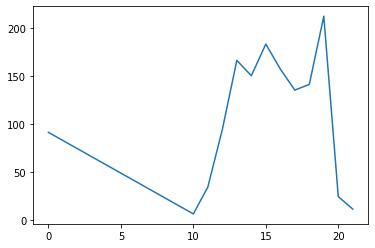

In [21]:
counter_info = Counter(count_info)
for key, value in counter_info.items():
    print(value, " livres ont ", key, " informations")
print("\n Nombre de livre par nombre d'information disponible")
x, y = zip(*sorted(counter_info.items()))
plt.plot(x,y)
plt.show()

- 91 livres sont totalement vides

Commentaire entre parenthèse pour les auteurs:

In [22]:
exemple = {}
for isbn, cpt in Hurtubise_books["Contributeurs_by_value"].items():
    if isbn:
        if "(" in isbn:
            txt_parentheses = text_between_parentheses(isbn)
            for ex in txt_parentheses:
                if ex not in exemple:
                    exemple[ex] = 0
                exemple[ex] += 1
exemple = [(k, v) for k, v in sorted(exemple.items(), key=lambda item: item[1], reverse=True)]
for ex, nb in exemple:
    print("exemple de texte entre parenthèses dans les isbns: ", ex, ": ", nb)


exemple de texte entre parenthèses dans les isbns:  (De ) :  594
exemple de texte entre parenthèses dans les isbns:  (auteur) :  462
exemple de texte entre parenthèses dans les isbns:  (Traduit par) :  112
exemple de texte entre parenthèses dans les isbns:  (Coordination éditoriale de) :  14
exemple de texte entre parenthèses dans les isbns:  (Illustré par) :  7
exemple de texte entre parenthèses dans les isbns:  (Préface de) :  4
exemple de texte entre parenthèses dans les isbns:  (photographe) :  3
exemple de texte entre parenthèses dans les isbns:  (Photographies de) :  2
exemple de texte entre parenthèses dans les isbns:  (dit Larose) :  1
exemple de texte entre parenthèses dans les isbns:  (Texte de) :  1


### Babelio

#### Global


In [23]:

Babaelio_loading_time = time.time()
babelioJson = open("./Babelio/item.json", "r")
babelioData = json.load(babelioJson)[0:]
babelioJson.close()

stats_book = {
    "total": 0
}
stats_author = {
    "total": 0
}
tags_count = []
for babelio_item in babelioData:
    # on check si il s'agit d'un livre ou d'un auteur
    if "author_id" in babelio_item:
        stats_book["total"] += 1
        tags_counter_i = 0
        # si c'est un auteur, on parcours ses attributs
        for key, value in babelio_item.items():
            # si la clef n'existe pas, on créé une nouvelle catégorie
            if key not in stats_book:
                stats_book[key] = 0
            # si le compte par occurence n'existe pas, on l'instancie
            if key + "_by_value" not in stats_book:
                    stats_book[key + "_by_value"] = {"None": 0}
            # traitement des catégories où l'objet est une simple chaine de caractère
            if key not in ["reviews", "extracts", "author", "resume", "tags"]:
                if value:
                    # si la valeur n'est pas dans le compte par occurence, on l'ajoute
                    if value not in stats_book[key + "_by_value"]:
                        stats_book[key + "_by_value"][value] = 0
                    # sinon, on compte +1 pour cette valeur
                    stats_book[key + "_by_value"][value] += 1
                    stats_book[key] += 1
                else:
                    stats_book[key + "_by_value"]["None"] += 1
            # pour l'auteur ou le résumé, on doit regrouper les informations avant de les compter,
            # car c'est un tableau de chaine de caractère, on ne veut pas considérer "jean" comme une valeur,
            # mais bien "jean nom_de_famille" par exemple
            elif key == "author" or key == "resume":
                if value:
                    if " ".join(value) not in stats_book[key + "_by_value"]:
                        stats_book[key + "_by_value"][" ".join(value)] = 0
                    stats_book[key + "_by_value"][" ".join(value)] += 1
                    stats_book[key] += 1
                else:
                    stats_book[key + "_by_value"]["None"] += 1
                
            # pour les tags, on doit faire la différence entre les tags,
            # et donc compter les tags individuellement
            elif key == "tags":
                for value_ in value:
                    tags_counter_i += 1
                    if value_:
                        if value_["tag"] not in stats_book[key + "_by_value"]:
                            stats_book[key + "_by_value"][value_["tag"]] = 0
                        stats_book[key + "_by_value"][value_["tag"]] += 1
                        stats_book[key] += 1
                    else:
                        stats_book[key + "_by_value"]["None"] += 1
            # cas où les informations sont sous une couche de plus (reviews et extract)
            # exemple: reviews ont un identifiant, un auteur, etc...
            # on doit donc faire une couche de plus d'analyse
            else:
                if value:
                    for key_, value_ in value[0].items():
                        if key_ not in stats_book[key + "_by_value"]:
                            stats_book[key + "_by_value"][key_] = 0
                        if key_ == 'author' or key_ == 'content':
                            value_ = " ".join(value_)
                        if key_ + "_by_value" not in stats_book[key + "_by_value"]:
                            stats_book[key + "_by_value"][key_ + "_by_value"] = {"None": 1}
                        if value_:
                            if value_ not in stats_book[key + "_by_value"][key_ + "_by_value"]:
                                stats_book[key + "_by_value"][key_ + "_by_value"][value_] = 0
                            stats_book[key + "_by_value"][key_ + "_by_value"][value_] += 1
                            stats_book[key + "_by_value"][key_] += 1
                        else:
                            stats_book[key + "_by_value"][key_ + "_by_value"]["None"] += 1
                    
                    stats_book[key] += 1
                else:
                    stats_book[key + "_by_value"]["None"] += 1 
            
        tags_count.append(tags_counter_i)
    else:
        stats_author["total"] += 1
        for key, value in babelio_item.items():
            if key not in stats_author:
                stats_author[key] = 0
            if key + "_by_value" not in stats_author:
                stats_author[key + "_by_value"] = {"None": 0}
            if key not in ["bio", "tags", "friends", 'bibliography', 'media', 'prices']:
                if value:
                    if value not in stats_author[key + "_by_value"]:
                        stats_author[key + "_by_value"][value] = 0
                    stats_author[key + "_by_value"][value] += 1
                    stats_author[key] += 1
                else:
                    stats_author[key + "_by_value"]["None"] += 1
            elif key == "bio":
                if value:
                    if " ".join(value) not in stats_author[key + "_by_value"]:
                        stats_author[key + "_by_value"][" ".join(value)] = 0
                    stats_author[key + "_by_value"][" ".join(value)] += 1
                    stats_author[key] += 1
                else:
                    stats_author[key + "_by_value"]["None"] += 1
            elif key == "tags":
                for value_ in value:
                    if value_:
                        if value_["tag"] not in stats_author[key + "_by_value"]:
                            stats_author[key + "_by_value"][value_["tag"]] = 0
                        stats_author[key + "_by_value"][value_["tag"]] += 1
                        stats_author[key] += 1
                    else:
                        stats_author[key + "_by_value"]["None"] += 1

            elif key in ["friends", 'bibliography', 'prices']:
                for value_ in value:
                    if value_:
                        if value_ not in stats_author[key + "_by_value"]:
                            stats_author[key + "_by_value"][value_] = 0
                        stats_author[key + "_by_value"][value_] += 1
                        stats_author[key] += 1
                    else:
                        stats_author[key + "_by_value"]["None"] += 1

            elif key == 'media':
                if value:
                    for key_, value_ in value[0].items():
                        if key_ not in stats_author[key + "_by_value"]:
                            stats_author[key + "_by_value"][key_] = 0
                        if key_ + "_by_value" not in stats_author[key + "_by_value"]:
                            stats_author[key + "_by_value"][key_ + "_by_value"] = {"None": 0}
                        if value_:
                            if key_ == 'author' or key_ == 'description':
                                value_ = " ".join(value_)
                            if value_ not in stats_author[key + "_by_value"][key_ + "_by_value"]:
                                stats_author[key + "_by_value"][key_ + "_by_value"][value_] = 0
                            stats_author[key + "_by_value"][key_ + "_by_value"][value_] += 1
                            stats_author[key + "_by_value"][key_] += 1
                        else:
                            stats_author[key + "_by_value"][key_ + "_by_value"]["None"] += 1
                else:
                    stats_author[key + "_by_value"]["None"] += 1 

print("babelio_loading_time: ", time.time() - Babaelio_loading_time)
_ = format_result(stats_book)


babelio_loading_time:  1.0248770713806152
{
  "total": 2041,
  "url": 2041,
  "url_by_value": {
    "https://www.babelio.com/livres/Letourneau-Notre-Duplex/655410": 1,
    "https://www.babelio.com/livres/Lepage-Vers-lOuest/152344": 1,
    "https://www.babelio.com/livres/Belisle-Planete-verte/710115": 1,
    "https://www.babelio.com/livres/Cloutier-Independance-Le-PQ-a-trahi-ses-militants/1129490": 1,
    "https://www.babelio.com/livres/Brisebois-Coups-de-feu-au-Forum/723616": 1,
    "https://www.babelio.com/livres/Girard-Les-Belles-Soeurs--Loeuvre-qui-a-tout-change/1038624": 1,
    "https://www.babelio.com/livres/Morgan-Les-Flibustieres-Bonny-Read/934415": 1,
    "https://www.babelio.com/livres/Barranger-Maria-chappe-de-haine/287218": 1,
    "https://www.babelio.com/livres/Jacques-La-tete-de-mort/1184443": 1,
    "https://www.babelio.com/livres/Leclerc-La-vie-rurale-1866-1953/542075": 1
  },
  "title": 2041,
  "title_by_value": {
    " Mon pays à feu et à sang ": 2,
    " Sociologie co

#### Commentaire:

total: 2041 livres

valeurs nulles:
- 451 livres n'ont pas de note soit 22%
- 51 livres n'ont pas de résumé soit 2%
- 921 livres n'ont pas de nombre de pages soit 45%


158  livres ont  9  tags
187  livres ont  7  tags
169  livres ont  8  tags
79  livres ont  10  tags
296  livres ont  20  tags
102  livres ont  2  tags
18  livres ont  1  tags
217  livres ont  6  tags
21  livres ont  17  tags
220  livres ont  5  tags
243  livres ont  4  tags
197  livres ont  3  tags
14  livres ont  19  tags
18  livres ont  18  tags
25  livres ont  11  tags
13  livres ont  16  tags
17  livres ont  15  tags
20  livres ont  14  tags
19  livres ont  12  tags
8  livres ont  13  tags

 Nombre de livre par nombre de tags


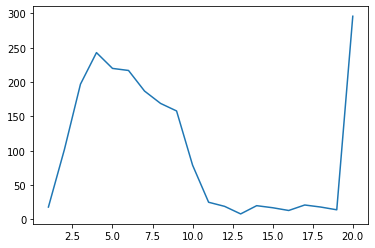

In [24]:
tags_counter = Counter(tags_count)
total = 0
for key, value in tags_counter.items():
    total += int(key) * int(value)
    print(value, " livres ont ", key, " tags")

print("\n Nombre de livre par nombre de tags")
x, y = zip(*sorted(tags_counter.items()))
plt.plot(x,y)
plt.show()
